<a href="https://colab.research.google.com/github/HikariJadeEmpire/THNumber_img_classification/blob/main/numberclassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
#pip install opencv-python
#pip install tensorflow      # keras is run on tensorflow so install tensorflow first
# vv 
#pip install keras

# Choose one (for Cross Validation)
#pip install pycaret
#pip install tune-sklearn ray[tune]

# STEP 1 : Importing

In [2]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Importing OpenCV - the computer vision library
import cv2

# import the modules - Directory management
import glob
import os
from os import listdir

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Neural Network
from tensorflow import keras
from tensorflow.keras import layers

# STEP 1.1 : SET an important Variables

In [5]:
main_dir = "./Thainumber"

# <h2>STEP 1.2 : Note ( It's not necessary to use. )</h2>

In [6]:
# get the path/directory

Zero_dir = main_dir + "/0"

#for images in os.listdir(One_dir):
 
    # check if the image ends with png
#    if (images.endswith(".png")):
#        print(images)

Original Image Shape (28, 28, 3)


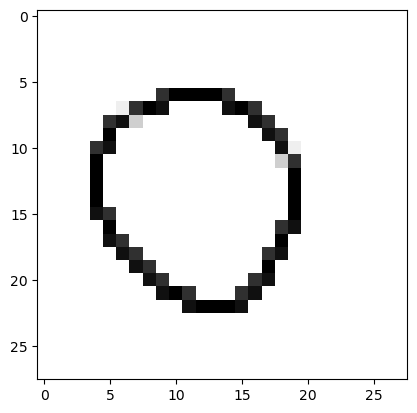

In [7]:
#To read the image 
bgrimg = cv2.imread(str(Zero_dir+'/0-2.png'))

plt.imshow(bgrimg)

#To get rid of the x-ticks and y-ticks on the image axis
#plt.xticks([])
#plt.yticks([])

print('Original Image Shape',bgrimg.shape)

In [8]:
#cv2.imread(str(Zero_dir+'/IMG_0953.png'))

# STEP 2 : Preparing & inspection

Prepare for inspections

In [9]:
file_path_all = list( glob.glob( main_dir + '/**/*.png' ) )

In [10]:
labels = list( map(lambda x: os.path.split( os.path.split(x)[0] )[1] , file_path_all) )

filepath = pd.Series(file_path_all, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

data = pd.concat([filepath, labels], axis=1)

data = data.sample(frac=1).reset_index(drop=True)   # Return a random sample of items from an axis of object.
data

,Filepath,Label
0,./Thainumber\0\0-2.png,0
1,./Thainumber\1\1-3.png,1
2,./Thainumber\6\6-03.png,6
3,./Thainumber\9\9-5.png,9
4,./Thainumber\3\IMG_0886.png,3
...,...,...
295,./Thainumber\2\IMG_0878.png,2
296,./Thainumber\6\IMG_0919.png,6
297,./Thainumber\2\two3.png,2
298,./Thainumber\0\zero5.png,0


In [11]:
data.shape

(300, 2)

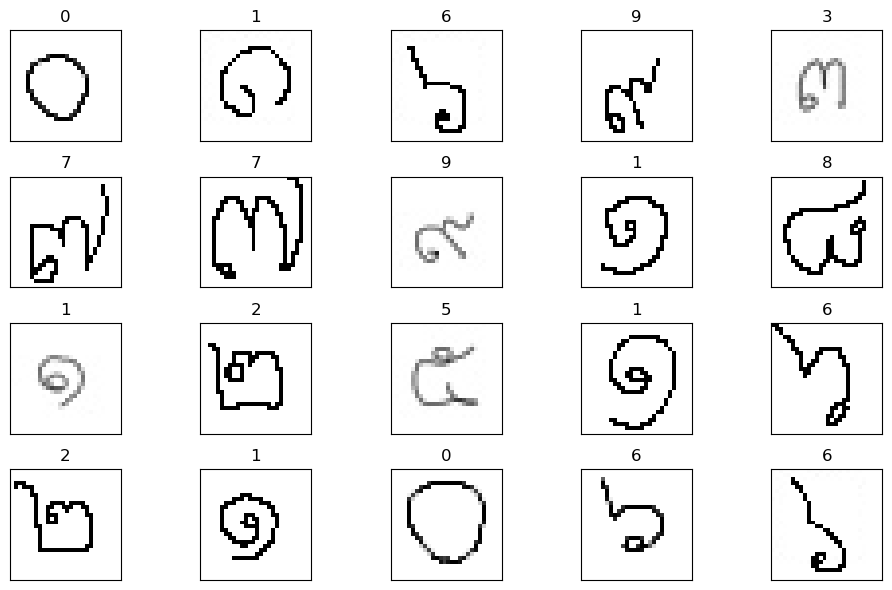

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,6), subplot_kw = {'xticks':[],'yticks':[]} )

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Counts')

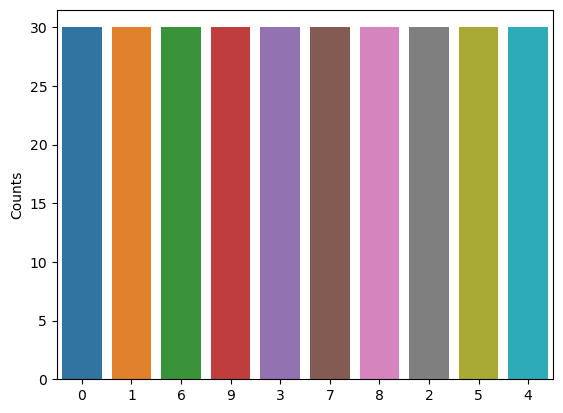

In [13]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.ylabel('Counts')

Prepare for Training

In [14]:
# Prepare X and Y

Before_x = data['Filepath']
y = data['Label']

# To work with X, we need to flatten the images first.
read_x = []

for i in Before_x :
    img_arr = cv2.imread(i)
    img_arr = cv2. cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    img_arr = np.expand_dims(img_arr, 2)
    read_x.append(img_arr)

Almost_x = np.array(read_x)
x = Almost_x/255       # Devide by 255 is to Normalization

In [15]:
print( y.unique(), '\n' )

# Binarize the output

y = preprocessing.label_binarize( y , classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'] )
print(y)

['0' '1' '6' '9' '3' '7' '8' '2' '5' '4'] 

[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


# STEP 3 : Build a Model ( NN, such as set hidden layers , etc. )

In [ ]:
# Build and compile model

model = Sequential()
model.add(Flatten())
model.add(Dense(100, activation='relu', input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# STEP 4 : Train

In [17]:
X_train, X_test , y_train, y_test = train_test_split( x, y , test_size=0.3, random_state=42 )

print('Train shape =>',X_train.shape , X_test.shape)
print('Test shape =>',y_train.shape , y_test.shape )

Train shape => (210, 28, 28, 1) (90, 28, 28, 1)
Test shape => (210, 10) (90, 10)
